In [23]:
import random
import matplotlib.pyplot as plt
import tqdm
from time import sleep
from IPython.display import clear_output

# Defining the problem, fitness function and language representation

For this genetic programming problem we have a grid world with food along a trail
which is sparsely laid out.

The canonical trail is shown below. The ant starts at the top left facing to the
right.

```
> # # # . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . # . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . # . . . . . . . . . . . . . . . . . . . . . # # # . . . . 
. . . # . . . . . . . . . . . . . . . . . . . . # . . . . # . . 
. . . # . . . . . . . . . . . . . . . . . . . . # . . . . # . . 
. . . # # # # . # # # # # . . . . . . . . # # . . . . . . . . . 
. . . . . . . . . . . . # . . . . . . . . . . . . . . . . # . . 
. . . . . . . . . . . . # . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . # . . . . . . . # . . . . . . . . . . . 
. . . . . . . . . . . . # . . . . . . . # . . . . . . . . # . . 
. . . . . . . . . . . . # . . . . . . . # . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . # . . . . . . . . . . . 
. . . . . . . . . . . . # . . . . . . . . . . . . . . . . # . . 
. . . . . . . . . . . . # . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . # . . . . . . . # . . . . . # # # . . . 
. . . . . . . . . . . . # . . . . . . . # . . # . . . . . . . . 
. . . . . . . . . . . . . . . . . # . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . # . . . # . . . . . . . # . . . . . . . 
. . . . . . . . . . . . # . . . # . . . . . . . . . . # . . . . 
. . . . . . . . . . . . # . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . # . . . # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . # . . . . . . . . . . . . . # . . . . . 
. . . . . . . . . . . . # . . . . . . . . . . # . . . . . . . . 
. . . # # . . # # # # # . . . . # . . . . . . . . . . . . . . . 
. # . . . . . . . . . . . . . . # . . . . . . . . . . . . . . . 
. # . . . . . . . . . . . . . . # . . . . . . . . . . . . . . . 
. # . . . . . . # # # # # # # . . . . . . . . . . . . . . . . . 
. # . . . . . # . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . # . . . . . . . . . . . . . . . . . . . . . . . . 
. . # # # # . . . . . . . . . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
```

Our ant has the following capabilities:
- Moving forward
- Rotating 90 degrees left or right
- Sensing if there is food directly in front of it

Translating this into a genetic programming task me can define the following
terminal set: `MOVE, LEFT, RIGHT`. For the functional set we will use
`IF_SENSE, PROG2, PROG3`. The if function will run it's first argument if there
is food directly in front of it in the environment. The other two run their arguments
in sequence which allows us to have sequential instructions.

These can be combined using a Lisp-like syntax to form programs. For example,
`(IF_SENSE MOVE RIGHT)` will move the ant forward if it senses food, and rotate
the ant clockwise otherwise. Thus, an optimal program for this environment would be:
`(IF_SENSE MOVE (PROG2 LEFT (IF_SENSE MOVE (PROG2 LEFT (IF_SENSE MOVE (PROG2 LEFT (IF_SENSE MOVE (PROG2 LEFT MOVE))))))))`

These programs cannot loop so we will allow the ant a maximum of 500 terminal
actions.

In [2]:
# Implement the environment, runner and language features
_sf_init = """.###............................
...#............................
...#.....................###....
...#....................#....#..
...#....................#....#..
...####.#####........##.........
............#................#..
............#...................
............#.......#...........
............#.......#........#..
............#.......#...........
....................#...........
............#................#..
............#...................
............#.......#.....###...
............#.......#..#........
.................#..............
................#...............
............#...#.......#.......
............#...#..........#....
............#...................
............#...#...............
............#.............#.....
............#..........#........
...##..#####....#...............
.#..............#...............
.#..............#...............
.#......#######.................
.#.....#........................
.......#........................
..####..........................
................................"""



TERMINALS = {'MOVE', 'LEFT', 'RIGHT'}
NONTERMINALS = {'IF_SENSE', 'PROG2', 'PROG3'}
NONTERMINAL_ARGS = {'IF_SENSE':2, 'PROG2':2, 'PROG3':3}

class State:
    def __init__(self) -> None:
        self._board = [[c == '#' for c in line] for line in _sf_init.split('\n')]
        self._height = len(self._board)
        self._width = len(self._board[0])
        self._ant = (0,0)
        self._dir = 1
        self._dirs = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        self._dir_str = ['v', '>', '^', '<']
        self.collected = 0
        self.steps = 0

    def take_action(self, action: str):
        fns = {
            'MOVE': self.action_move,
            'LEFT': self.action_left,
            'RIGHT': self.action_right,
        }
        fns[action]()

    def action_move(self):
        self.steps += 1
        self._ant = (self._ant[0] + self._dirs[self._dir][0]) % self._width, \
            (self._ant[1] + self._dirs[self._dir][1]) % self._height

        if self[self._ant]:
            self[self._ant] = False
            self.collected += 1

    def action_left(self):
        self.steps += 1
        self._dir = (self._dir - 1) % 4

    def action_right(self):
        self.steps += 1
        self._dir = (self._dir + 1) % 4

    def sense_food(self):
        pos = (self._ant[0] + self._dirs[self._dir][0]) % self._width,\
                 (self._ant[1] + self._dirs[self._dir][1]) % self._height

        return self[pos]

    def __getitem__(self, key):
        if not isinstance(key, tuple) or len(key) != 2 or not all(isinstance(k, int) for k in key):
            raise TypeError('Key must be a size 2 tuple of positive integers.')
        return self._board[key[1]][key[0]]

    def __setitem__(self, key, value):
        if not isinstance(key, tuple) or len(key) != 2 or not all(isinstance(k, int) for k in key):
            raise TypeError('Key must be a size 2 tuple of positive integers.')
        if not isinstance(value, bool):
            raise TypeError('Board values should be booleans.')

        self._board[key[1]][key[0]] = value

    def __str__(self) -> str:
        board = ''
        for y, row in enumerate(self._board):
            for x, c in enumerate(row):
                if (x,y) == self._ant:
                    board += self._dir_str[self._dir]
                elif self[x,y]:
                    board += 'X'
                else:
                    board += ' '
                
                board += ' '
            board += '\n'

        return board


def smartsplit(s):
    output = []
    start = 0
    count = 0
    for i, c in enumerate(s):
        assert(count >= 0)
        if c == '(':
            count += 1
        elif c == ')':
            count -= 1
        elif c == ' ' and count == 0 and start < i - 1:
            output.append(s[start:i])
            start = i + 1
    assert(count == 0)
    if count == 0 and start < len(s):
        output.append(s[start:])
    return output

def smartstrip(s):
    if s.startswith('(') and s.endswith(')'):
        return s[1:-1]
    else:
        return s

class Node:
    def __init__(self, s = None) -> None:
        if s is not None:
            pass # Recursively init program
            self.cmd, *self.children = smartsplit(smartstrip(s))
            self.children = [Node(c) for c in self.children]
        else:
            self.cmd = None
            self.children = []
    
    def truncate_depth(self, max_depth, _depth=0):
        if _depth >= max_depth:
            # Truncate
            if self.cmd not in {'LEFT', 'RIGHT', 'MOVE'}:
                self.cmd = ['LEFT', 'RIGHT','MOVE'][random.randint(0,2)]
                self.children = []
        else:
            for child in self.children:
                child.truncate_depth(max_depth, _depth+1)

    def num_nodes(self) -> int:
        return 1 + sum((c.num_nodes() for c in self.children))

    def max_depth(self) -> int:
        if len(self.children) == 0:
            return 0
        else:
            return 1 + max((c.max_depth() for c in self.children))
            
    def __repr__(self) -> str:
        return f"Node(cmd='{self.cmd}', {len(self.children)} children)"

    def _to_string(self) -> str:
        """
        Returns lisp-like string to represent the program
        """
        if self.children:
            return '(' + self.cmd + ' ' + ' '.join((c._to_string() for c in self.children)) + ')'
        else:
            return self.cmd

    def to_string(self) -> str:
        if self.children:
            return self._to_string()
        else:
            return '(' + self._to_string() + ')'

    def __hash__(self) -> int:
        return hash(self.to_string())

    @staticmethod
    def get_flat_nodes(node):
        # DFS through program to build (parent, child_idx, depth, node) tuples

        output = []
        frontier = [(None, None, 0, node)]
        while frontier:
            state = frontier.pop()
            output.append(state)

            _, _, depth, node = state
            for i, child in enumerate(node.children):
                frontier.append((node, i, depth + 1, child))
        
        return output

In [6]:
# Genetic Operators
def gen_random_program(max_depth, depth=0):
    if depth >= max_depth:
        return Node(random.sample(TERMINALS,1)[0])
    else:
        cmd = random.sample(TERMINALS | NONTERMINALS, 1)[0]
        if cmd in NONTERMINALS:
            node = Node()
            node.cmd = cmd
            node.children = [gen_random_program(max_depth, depth + 1) for _ in range(NONTERMINAL_ARGS[cmd])]
            return node
        else:
            return Node(cmd)

def mutate_program(prog, max_depth):
    prog = Node(prog.to_string())
    nodes = Node.get_flat_nodes(prog)

    # Uniformly select node to mutate
    parent, id, depth, node = random.choice(nodes)
    if parent is None:
        return gen_random_program(max_depth)
    
    parent.children[id] = gen_random_program(max_depth - depth)
    return prog

def mutate_pointwise(prog, mutation_rate=0.1):
    prog = Node(prog.to_string())
    nodes = Node.get_flat_nodes(prog)

    for parent, id, depth, node in nodes:
        if random.random() > mutation_rate:
            continue

        if node.cmd in {'MOVE', 'LEFT', 'RIGHT'}:
            node.cmd = random.choice(['MOVE', 'LEFT', 'RIGHT'])
        elif node.cmd in {'PROG2', 'IF_SENSE'}:
            node.cmd = random.choice(['PROG2', 'IF_SENSE'])

    return prog

def crossover_program(prog1, prog2, max_depth=None):
    prog1 = Node(prog1.to_string())
    prog1_nodes = Node.get_flat_nodes(prog1)
    prog2 = Node(prog2.to_string())
    prog2_nodes = Node.get_flat_nodes(prog2)

    parent1, id1, _, node1 = random.choice(prog1_nodes)
    parent2, id2, _, node2 = random.choice(prog2_nodes)
    if parent1 is None:
        prog1 = node2
    else:
        parent1.children[id1] = node2

    if parent2 is None:
        prog2 = node1
    else:
        parent2.children[id2] = node1

    if max_depth is not None:
        prog1.truncate_depth(max_depth)
        prog2.truncate_depth(max_depth)

    return prog1, prog2

def tournament_selection(pop, k=5):
    inds = random.sample(range(len(pop)), k)
    best = max([pop[i] for i in inds], key=lambda x: x[1])[0]
    return Node(best.to_string())

In [12]:
MAX_FITNESS = 89
OPT = """(IF_SENSE MOVE (PROG2 LEFT (IF_SENSE MOVE (PROG2 LEFT (IF_SENSE MOVE (PROG2 LEFT (IF_SENSE MOVE (PROG2 LEFT MOVE))))))))"""

def run(program: Node, board: State = State(), max_steps=500):
    # Repeatedly run program while we have steps
    while board.steps < max_steps:

        # Run program
        commands = [program]
        while commands:
            if board.steps >= max_steps:
                break

            node = commands.pop()

            # print(board)
            # print(f"Next action: {node.cmd}")
            # input()

            if node.cmd in TERMINALS:
                board.take_action(node.cmd)
            elif node.cmd == 'IF_SENSE':
                assert(len(node.children) == 2)
                if board.sense_food():
                    commands.append(node.children[0])
                else:
                    commands.append(node.children[1])
            elif node.cmd.startswith('PROG'):
                n = int(node.cmd[-1])
                assert(len(node.children) == n)
                commands.extend(reversed(node.children))
            else:
                raise Exception(f'Invalid command {node.cmd}')

    return board.collected


def gp_search(
    max_tree_depth,
    max_generations,
    pop_size,
    elitism_k,
    tournament_k,
    mutation_prob
):
    # Create initial population
    pop = [gen_random_program(max_tree_depth) for _ in range(pop_size)]
    pop = [(p, run(p, State())) for p in pop]

    gen = 0
    worst, avg, best = [],[],[]
    pbar = tqdm.tqdm(total=max_generations)
    while gen < max_generations:
        # Top 5 elitism
        new_pop = {Node(p.to_string()) for p, _ in pop[elitism_k:]}
        # Build new population
        while len(new_pop) < pop_size:
            # Mix between reproduced individuals and 
            # cross over individuals 
            # with elitism
            if random.random() < 0.5: # Mutation
                ind = tournament_selection(pop, k=tournament_k)
                if random.random() < mutation_prob:
                    new_pop.add(mutate_program(ind, max_depth=max_tree_depth))
                else:
                    new_pop.add(Node(ind.to_string()))
            else: # crossover
                ind1 = tournament_selection(pop, k=tournament_k)
                ind2 = tournament_selection(pop, k=tournament_k)

                c1, c2 = crossover_program(ind1, ind2, max_depth=max_tree_depth)
                if random.random() < mutation_prob:
                    c1 = mutate_program(c1, max_depth=max_tree_depth)
                if random.random() < mutation_prob:
                    c2 = mutate_program(c2, max_depth=max_tree_depth)
                
                new_pop.update([c1, c2])
        pop = list(new_pop)

        # Eval population fitness
        pop = [(p, run(p, State())) for p in pop]
        pop.sort(key=lambda x: x[1])

        worst.append(pop[0][1])
        best.append(pop[-1][1])
        avg.append(sum((f for _, f in pop)) / len(pop))

        # If best is max, break
        if pop[-1][0] == MAX_FITNESS:
            break

        gen += 1
        pbar.update()

    pbar.close()


    # # Graph generations
    plt.figure()

    # Fitness plot
    plt.subplot(2,1,1)
    x = list(range(max_generations))
    plt.plot(x, worst)
    plt.plot(x, avg)
    plt.plot(x, best)
    plt.legend(['Worst', 'Avg', 'Best'])
    plt.ylim(0, MAX_FITNESS)
    plt.xlabel('Generations')
    plt.ylabel('Fitness')

    plt.show()

    # # Return best program
    print(f"Best fitness: {pop[-1][1]}")
    print(pop[-1][0].to_string())

# Design

The initial population is uniformly randomly generated. See `gen_random_program()`
above for details.

For selection I used tournament selection. Mutation was done by randomly
selecting a location on the tree and mutating it into a random subtree.
Crossover was done with basic subtree swapping between the two parents.

All depth is bounded to max_depth.

The genetic programming parameters can be seen below.

100%|██████████| 300/300 [02:51<00:00,  1.75it/s]


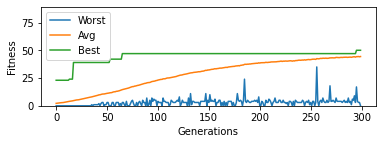

Best fitness: 50
(IF_SENSE MOVE (PROG2 (PROG3 (PROG2 MOVE (IF_SENSE (PROG3 MOVE (PROG2 RIGHT MOVE) RIGHT) (PROG2 (PROG3 MOVE RIGHT MOVE) MOVE))) (PROG2 MOVE LEFT) MOVE) MOVE))


In [14]:
config = {
    "max_tree_depth":7,
    "max_generations": 300,
    "pop_size" : 300,
    "elitism_k" : 5,
    "tournament_k" : 15,
    "mutation_prob" : 0.7
}

gp_search(**config)

To analyze our solution I'll format it and remove the `PROG` functions for
readability.

```
(IF_SENSE
    MOVE
    ---
    MOVE
    IF_SENSE
        MOVE
        RIGHT
        MOVE
        RIGHT
        ----
        MOVE
        RIGHT
        MOVE
        MOVE
    MOVE
    LEFT
    MOVE
    MOVE
)
```

Here we see that the solution has the obvious first step, that is, move if food
is sensed. However, the program seems to mainly explore the space by moving a 
number of steps and then turning right. If there is a trail of foot it will
follow it until it ends.

In [26]:
sln = "(IF_SENSE MOVE (PROG2 (PROG3 (PROG2 MOVE (IF_SENSE (PROG3 MOVE (PROG2 RIGHT MOVE) RIGHT) (PROG2 (PROG3 MOVE RIGHT MOVE) MOVE))) (PROG2 MOVE LEFT) MOVE) MOVE))"
prog = Node(sln)

def run_print(program: Node, board: State = State(), max_steps=500):
    # Repeatedly run program while we have steps
    while board.steps < max_steps:
        
        # Run program
        commands = [program]
        while commands:
            print(board)
            if board.steps >= max_steps:
                break

            node = commands.pop()

            # print(board)
            # print(f"Next action: {node.cmd}")
            # input()

            if node.cmd in TERMINALS:
                board.take_action(node.cmd)
            elif node.cmd == 'IF_SENSE':
                assert(len(node.children) == 2)
                if board.sense_food():
                    commands.append(node.children[0])
                else:
                    commands.append(node.children[1])
            elif node.cmd.startswith('PROG'):
                n = int(node.cmd[-1])
                assert(len(node.children) == n)
                commands.extend(reversed(node.children))
            else:
                raise Exception(f'Invalid command {node.cmd}')
        
            sleep(1)
            clear_output()

    return board.collected

In [27]:
# Animate the program
sln = "(IF_SENSE MOVE (PROG2 (PROG3 (PROG2 MOVE (IF_SENSE (PROG3 MOVE (PROG2 RIGHT MOVE) RIGHT) (PROG2 (PROG3 MOVE RIGHT MOVE) MOVE))) (PROG2 MOVE LEFT) MOVE) MOVE))"
prog = Node(sln)
run_print(prog)

                                                                
      X                                                         
      X                                           X X X         
      X                                         X         X     
      X                                         X         X     
      X X X X   X X X X X                 X X                   
                        X                                 X     
                        X                                       
                        X               X                       
                        X               X                 X     
                        X               X                       
                                        X                       
                        X                                 X     
                        X                                       
                        X               X           X X X       
                        X

KeyboardInterrupt: 